In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
t_data = pd.read_csv(r'C:\Users\김상휘\Desktop\Hwi\한이음-kt\data\telecom_data.csv', encoding='euc-kr',engine='python')
t_data.rename(columns= t_data.iloc[0],inplace=True)
t_data.drop(t_data.index[0],axis=0,inplace=True)

## 결측치 처리

In [4]:
t_data['TotalCharges'] = t_data['TotalCharges'].replace(" ",np.nan)
t_data.dropna(inplace=True)
t_data.drop('customerID',axis=1,inplace=True)

## 타입 변경하기

In [5]:
col1 = ['MonthlyCharges','TotalCharges']
for i in col1:
    t_data[i] = t_data[i].astype(float)

t_data['tenure'] = t_data['tenure'].astype(int)
t_data.dtypes

gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int32
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

## 이탈 = 1 / 이탈하지 않음 = 0

In [6]:
t_data.loc[t_data.Churn == 'No','Churn'] = 0
t_data.loc[t_data.Churn == 'Yes', 'Churn'] = 1
t_data.Churn = t_data.Churn.astype(int)

## 데이터 스케일링

#### 남은 임기 - MinMaxScaler

(0, 1)

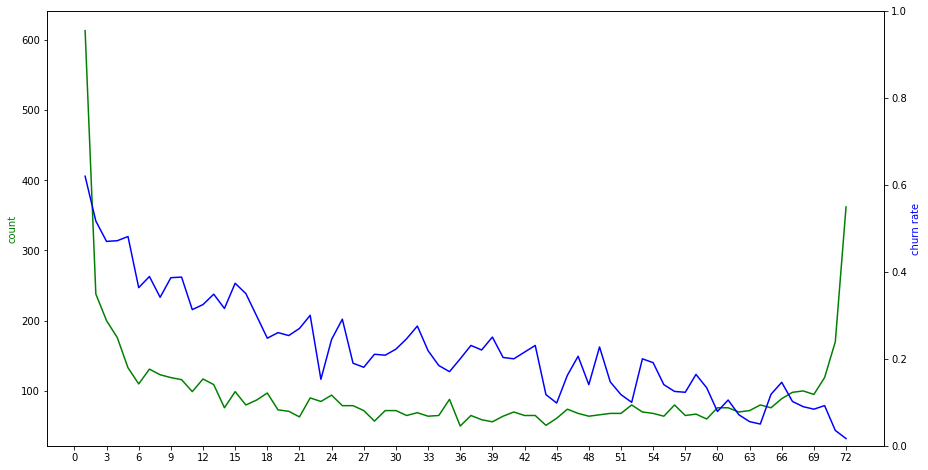

In [7]:
t_tenure = t_data.tenure.value_counts().sort_index()
x = t_tenure.index
y1 = t_tenure.values
y2 = t_data.groupby('tenure').Churn.mean().values

fig, ax1 = plt.subplots(figsize = (15,8))

ax2 = ax1.twinx()

ax1.plot(x,y1,'g-')
ax2.plot(x,y2,'b-')

ax1.set_xticks(range(0,73,3))
ax1.set_ylabel('count', color='g')
ax2.set_ylabel('churn rate', color='b')
ax2.set_ylim((0,1))

In [8]:
tenu = np.array(t_data.tenure).reshape(-1,1)
scaler = MinMaxScaler()
a = scaler.fit_transform(tenu)
t_data['tenure'] = a

#### 월 요금

(-1, 1.5)

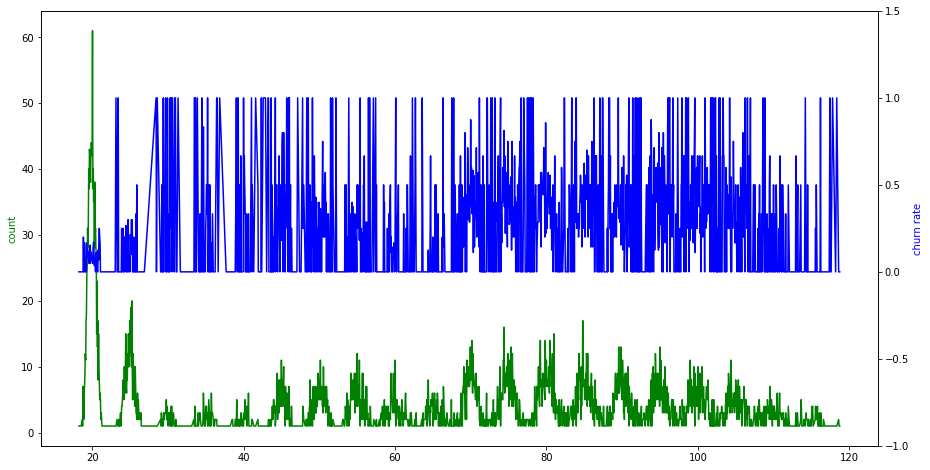

In [9]:
t_monthly = t_data.MonthlyCharges.value_counts().sort_index()
x = t_monthly.index
y1 = t_monthly.values
y2 = t_data.groupby('MonthlyCharges').Churn.mean().values

fig, ax1 = plt.subplots(figsize = (15,8))

ax2 = ax1.twinx()

ax1.plot(x,y1,'g-')
ax2.plot(x,y2,'b-')

ax1.set_ylabel('count', color='g')
ax2.set_ylabel('churn rate', color='b')
ax2.set_ylim((-1,1.5))

In [10]:
monthly = np.array(t_data.MonthlyCharges).reshape(-1,1)
scaler = MinMaxScaler()
a = scaler.fit_transform(monthly)
t_data['MonthlyCharges'] = a

#### 총 요금

In [11]:
total = np.array(t_data.TotalCharges).reshape(-1,1)
scaler = MinMaxScaler()
a = scaler.fit_transform(total)
t_data['TotalCharges'] = a

## 원 핫 인코딩

In [12]:
t_data_dummies = t_data.drop('Churn',axis=1)
t_data_dummies = pd.get_dummies(t_data_dummies)
t_data_dummies['Churn'] = t_data['Churn']

In [13]:
#t_data_dummies.to_csv(r'C:\Users\김상휘\Desktop\Hwi\한이음-kt\data\data_Hwi.csv',index=False)

# 모델링

## 1. 로지스틱 회귀

In [13]:
data = t_data_dummies.drop('Churn',axis=1)
target = t_data_dummies.Churn

X_train_val, X_test, y_train_val, y_test = train_test_split(data,target,random_state = 77)
X_train, X_val, y_train, y_val = train_test_split(X_train_val,y_train_val,random_state = 77)

In [14]:
logreg = LogisticRegression().fit(X_train,y_train)

#### 모델 평가

In [15]:
print('train set score : {}'.format(logreg.score(X_train,y_train)))
print('validation set score : {}'.format(logreg.score(X_val,y_val)))

train set score : 0.8040455120101138
validation set score : 0.7930250189537529


In [16]:
confusion_matrix(y_val, logreg.predict(X_val))

array([[875, 112],
       [161, 171]], dtype=int64)

In [17]:
print(classification_report(y_val,logreg.predict(X_val),target_names=['not churn','churn']))

              precision    recall  f1-score   support

   not churn       0.84      0.89      0.87       987
       churn       0.60      0.52      0.56       332

    accuracy                           0.79      1319
   macro avg       0.72      0.70      0.71      1319
weighted avg       0.78      0.79      0.79      1319



#### 최적의 매개변수 구하기 : crossvalidation+parametertuning

In [21]:
logreg = LogisticRegression()
param_grid = {'C' : [0.001,0.01,0.1,1,10,100,1000]}
grid = GridSearchCV(logreg,param_grid=param_grid,cv=5, scoring='roc_auc')
grid.fit(X_train_val,y_train_val)
print('Gridsearch by using AUC')
print('best parameter : {}'.format(grid.best_params_))
print('best AUC score of CV : {:.3f}'.format(grid.best_score_)) # 교차검증의 평균 정확도
print('best AUC score of test set : {:.3f}'.format(grid.score(X_test,y_test))) # 최적의 매개변수와 전체 train 데이터로 만든 모델로 평가한 점수

Gridsearch by using AUC
best parameter : {'C': 1000}
best AUC score of CV : 0.843
best AUC score of test set : 0.847


#### 테스트

In [23]:
logreg = LogisticRegression(C=1000)
logreg.fit(X_train_val,y_train_val)
print(classification_report(y_test,logreg.predict(X_test),target_names=['not churn','churn']))

              precision    recall  f1-score   support

   not churn       0.85      0.90      0.88      1289
       churn       0.68      0.57      0.62       469

    accuracy                           0.81      1758
   macro avg       0.76      0.73      0.75      1758
weighted avg       0.80      0.81      0.81      1758



#### 특성 중요도

In [24]:
importance = logreg.coef_[0]
df = pd.DataFrame(data=importance,index=X_train.columns,columns=['importance'])
df = df.sort_values(by='importance')

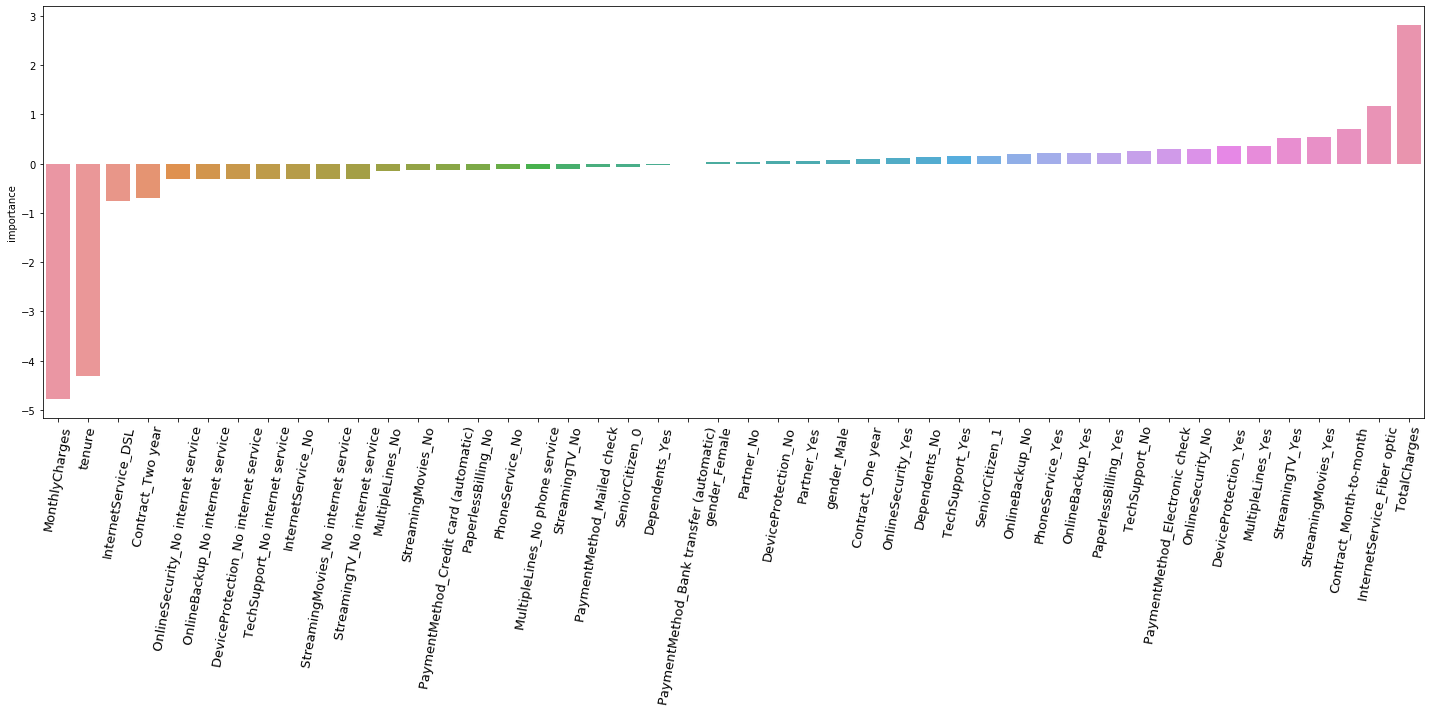

In [25]:
plt.figure(figsize=(20,10))
ax = sns.barplot(df.index,df.importance)
ax.set_xticklabels(df.index,rotation=80,fontsize=13)
plt.tight_layout()
plt.show()

## 2. LightGBM

In [29]:
model = lgb.LGBMClassifier(objective = 'binary',
                          metric = 'auc',
                          reg_alpha = 0,
                          reg_lambda = 2,
                          bagging_fraction = 0.999,
                          min_split_gain = 0,
                          min_child_samples = 10,
                          subsample_freq = 3,
                          subsample_for_bin = 50000,
                          n_estimators = 999,
                          verbose =-1
                          )
scores = cross_val_score(model,X_train_val,y_train_val, cv=5, scoring='roc_auc')

#### 모델 평가

In [33]:
print('best AUC score of CV : {:.3f}'.format(np.array(scores).mean())) # 교차검증의 평균 정확도

best AUC score of CV : 0.804


In [59]:
evals = [(X_test,y_test)]

In [61]:
model.fit(X_train_val,y_train_val)
y_pre = model.predict(X_test)
print('test set score : {:.3f}'.format((y_pre == y_test).mean()))

test set score : 0.776


In [51]:
print(classification_report(y_test,y_pre,target_names=['not churn','churn']))

              precision    recall  f1-score   support

   not churn       0.83      0.87      0.85      1289
       churn       0.59      0.51      0.55       469

    accuracy                           0.78      1758
   macro avg       0.71      0.69      0.70      1758
weighted avg       0.77      0.78      0.77      1758



#### 최적의 매개변수 구하기 : baysian optimization

In [55]:
def lgb_evaluate(numLeaves, maxDepth, scaleWeight, minChildWeight, subsample, colSam):
    model = lgb.LGBMClassifier(objective = 'binary',
                              metric = 'auc',
                              reg_alpha = 0,
                              reg_lambda = 2,
                              bagging_fraction = 0.999,
                              min_split_gain = 0,
                              min_child_samples = 10,
                              subsample_freq = 3,
                              subsample_for_bin = 50000,
                              n_estimators = 999,
                              num_leaves = int(numLeaves),
                              max_depth = int(maxDepth),
                              scale_pos_weight= scaleWeight,
                              min_child_weight= minChildWeight,
                              subsample= subsample,
                              colsample_bytree= colSam,
                              verbose =-1
                              )
    scores = cross_val_score(model,X_train_val,y_train_val, cv=5, scoring='roc_auc')
    return np.mean(scores)

In [53]:
def bayesOpt(X_train_val,y_train_val):
    lgbBO = BayesianOptimization(lgb_evaluate, {   'numLeaves':  (5, 90),  'maxDepth': (2, 90), 'scaleWeight': (1, 10000),  'minChildWeight': (0.01, 70),  'subsample': (0.4, 1),  'colSam': (0.4, 1)   })
    lgbBO.maximize(init_points=5, n_iter=50)
    print(lgbBO.res['max'])

In [56]:
bayesOpt(X_train_val,y_train_val)

|   iter    |  target   |  colSam   | maxDepth  | minChi... | numLeaves | scaleW... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.5581   |  0.4624   |  16.11    |  2.929    |  81.97    |  4.257e+0 |  0.4153   |
|  2        |  0.5      |  0.7462   |  68.0     |  29.02    |  20.27    |  7.939e+0 |  0.4464   |
|  3        |  0.5      |  0.6399   |  78.27    |  21.96    |  56.41    |  7.79e+03 |  0.5216   |
|  4        |  0.5      |  0.6625   |  10.74    |  53.27    |  7.428    |  9.608e+0 |  0.8407   |
|  5        |  0.816    |  0.782    |  31.08    |  65.88    |  85.43    |  2.76e+03 |  0.7188   |
|  6        |  0.8192   |  0.4233   |  68.13    |  50.46    |  77.18    |  2.452    |  0.4293   |
|  7        |  0.8142   |  0.4795   |  89.82    |  0.7094   |  19.38    |  1.35e+03 |  0.4059   |
|  8        |  0.8229   |  0.9144   |  6.796    |  64.21    |  87.04    |  1.764e+0 |  0.9409   |
|  9        |  0.819

|  51       |  0.5      |  0.4      |  2.0      |  70.0     |  90.0     |  8.419e+0 |  1.0      |
|  52       |  0.8297   |  0.8545   |  4.852    |  53.01    |  14.0     |  2.954    |  0.4008   |
|  53       |  0.828    |  0.7683   |  2.903    |  17.6     |  88.4     |  3.016e+0 |  0.5015   |
|  54       |  0.8152   |  0.9257   |  19.11    |  64.1     |  88.98    |  1.501e+0 |  0.9776   |
|  55       |  0.8291   |  0.6622   |  2.041    |  4.311    |  6.599    |  2.079e+0 |  0.9607   |


TypeError: list indices must be integers or slices, not str

d_train = lgb.Dataset(X_train,label = y_train)
d_val = lgb.Dataset(X_val,label = y_val)

params = {
    'application':'binary',
    'objective':'binary',
    'metric':'auc',
    'is_unbalance':True,
    'boosting':'gbdt',
    'num_leaves':144,
    'feature_fraction':0.7,
    'bagging_fraction':0.7,
    'bagging_freq':5,
    'learning_rate':0.05,
    'verbose':0,
    'seed':777
}

model = lgb.train(params, d_train, valid_sets = d_val, num_boost_round = 5000, early_stopping_rounds=100)

y_pre = model.predict(X_test)
for i in range(len(y_pre)):
    if y_pre[i] > 0.5:
        y_pre[i] = 1
    else:
        y_pre[i] = 0

#### 특성 중요도